In [127]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
%matplotlib inline
import h5py
from pathlib import Path
import numpy as np

textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

### Single site by hand:

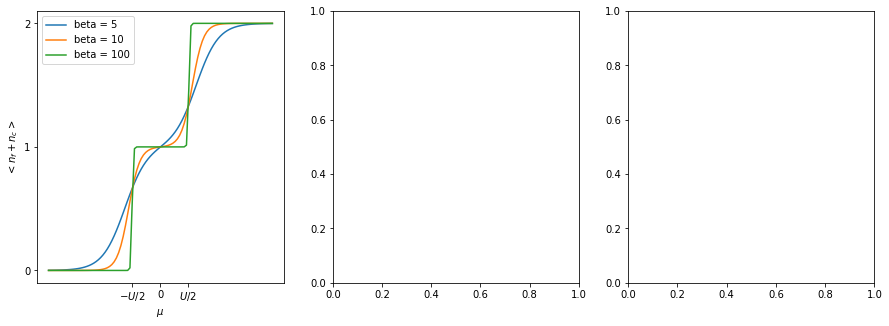

In [2]:
from itertools import product

#calculated this by hand
def rho_in_single_site_limit(mu, beta, U):
    Z = np.exp(-beta*(U /4)) + 2*np.exp(-beta*(-U /4 - mu)) + np.exp(-beta*(U /4 - 2*mu))  
    return 2*(np.exp(-beta*(-U /4 - mu)) + np.exp(-beta*(U /4 - 2*mu))) / Z

#A slightly more automatic way to do it
def non_symmetric_version(u, beta, U):
    Z = 0
    Nf = 0
    Nc = 0
    for nf in [0,1]:
        Ff = -U/2*(nf - 1/2) - mu*nf
        Hc = U*(nf - 1/2) - mu #Hc only has one energy level in the single site limit
        Fc = -1/beta * np.log(1 + np.exp(-beta*Hc))
        boltzman_factor = np.exp(-beta * (Fc + Ff))
        Z += boltzman_factor
        Nf += nf * boltzman_factor
        Nc += 1/(1 + np.exp(beta * Hc)) * boltzman_factor
    return Nf / Z, Nc / Z

mu = np.linspace(-2,2,100)
U = 1
f, (ax, axf,axc) = plt.subplots(1,3, figsize = (15,5))



for beta in [5, 10, 100]:
    Nf, Nc = non_symmetric_version(mu, beta=beta, U=U)
    #assert(np.allclose(Nf + Nc, rho_in_single_site_limit(mu, beta, U=U)))
    
    ax.plot(mu, Nf + Nc, label = f'beta = {beta}')
    
    ax.set(ylabel = '$<n_f + n_c>$', xlabel = '$\mu$',
           xticks = [-1/2,0, 1/2], xticklabels = ['$-U/2$', 0, '$U/2$'], yticks = [0,1,2])
ax.legend()

/workspace/tch14/conda-envs/cmth_intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


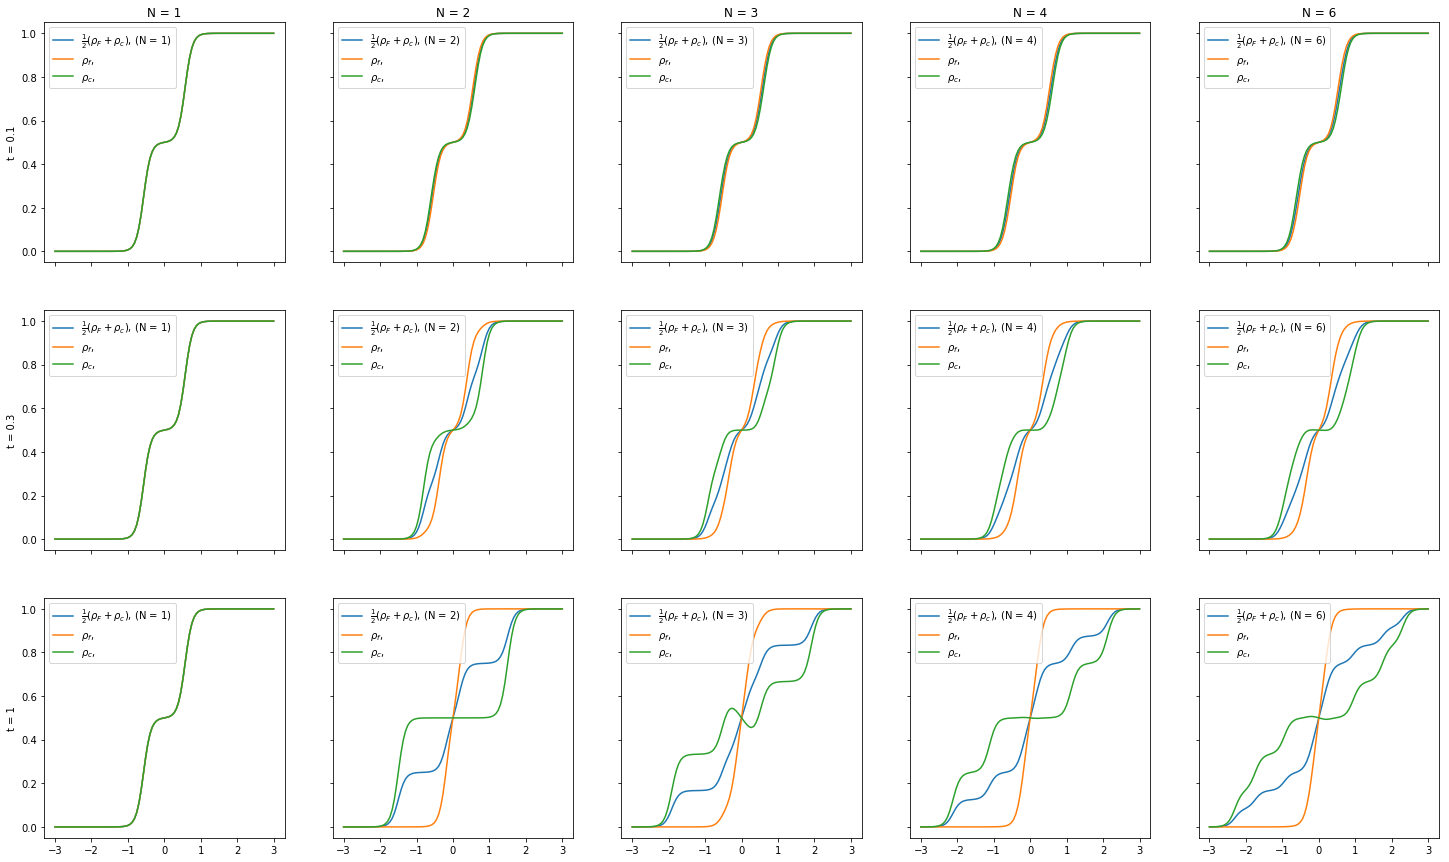

In [3]:
from scipy.linalg import eigh_tridiagonal, LinAlgError, circulant
from math import exp

def interaction_matrix(N, alpha, J, normalise = True, dtype = np.float64):
    alternating_signs = 2*(np.arange(1,N) % 2) - 1
    row0 = alternating_signs * np.abs((N/np.pi * np.sin(np.pi * np.arange(1,N, dtype = dtype)/N)) ** (-alpha))
    row0 = np.concatenate([[0,], row0])# put the first 0 in by hand
    if normalise: row0 = row0 / np.sum(row0)
    row0 = J * row0
    return circulant(row0)

def solve_H(state, mu, beta, U, J, t = 1):
    muf = muc = mu
    if state.size == 1:
        evals = np.array([U*(state - 1/2)])
        evecs = np.array([1,])
    else:
        evals, evecs = eigh_tridiagonal(d = U*(state - 1/2) - muc, e =-t*np.ones(state.shape[0] - 1), lapack_driver = 'stev')
        
    Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state) + (state - 1/2).T @ J @ (state - 1/2)
    Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))
    return Ff, Fc, evals, evecs

def direct_N(system_size, mu, beta, U, J, t = 1):
    Z = 0
    Nf = 0
    Nc = 0
    muf = muc = mu
    for state in product((0,1), repeat = system_size):
        state = np.array(state)
        if system_size > 1:
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J, t)
        elif system_size == 1:
            evals = np.array([U*(state - 1/2)]) - muc
            Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
            Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))    

        Boltz_factor = np.exp(- beta * (Ff + Fc))
        Z += Boltz_factor
        Nf += np.sum(state) * Boltz_factor
        Nc += np.sum(1 / (1 + np.exp(beta * evals))) * Boltz_factor
    
    return Nf / Z, Nc / Z

beta = 10
U = 1
J = 0
mu = np.linspace(-3,3,100)
Ns = [1,2,3,4,6]
ts = [0.1, 0.3, 1]

f, axes = plt.subplots(len(ts),len(Ns),figsize = (len(Ns)*5,len(ts)*5), sharex = 'col', sharey = 'row')

for row, t in zip(axes, ts):
    for ax, N in zip(row, Ns):
        J_matrix = interaction_matrix(N, 1.5, J, normalise = True, dtype = np.float64)
        Nf, Nc = np.array([direct_N(N, m, beta, U, J=J_matrix, t=t) for m in mu]).T
        Nt = (Nf + Nc)
        ax.plot(mu, Nt/(2*N), label = r'$\frac{1}{2}(\rho_F + \rho_c)$,' +f' (N = {N})')
        ax.plot(mu, Nf/N, label = r'$\rho_f$,')
        ax.plot(mu, Nc/N, label = r'$\rho_c$,')
        ax.legend()
        
for ax,N in zip(axes[0],Ns): ax.set(title = f'N = {N}') 
for ax,t in zip(axes.T[0], ts): ax.set(ylabel = f't = {t}') 
        
    

/workspace/tch14/conda-envs/cmth_intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


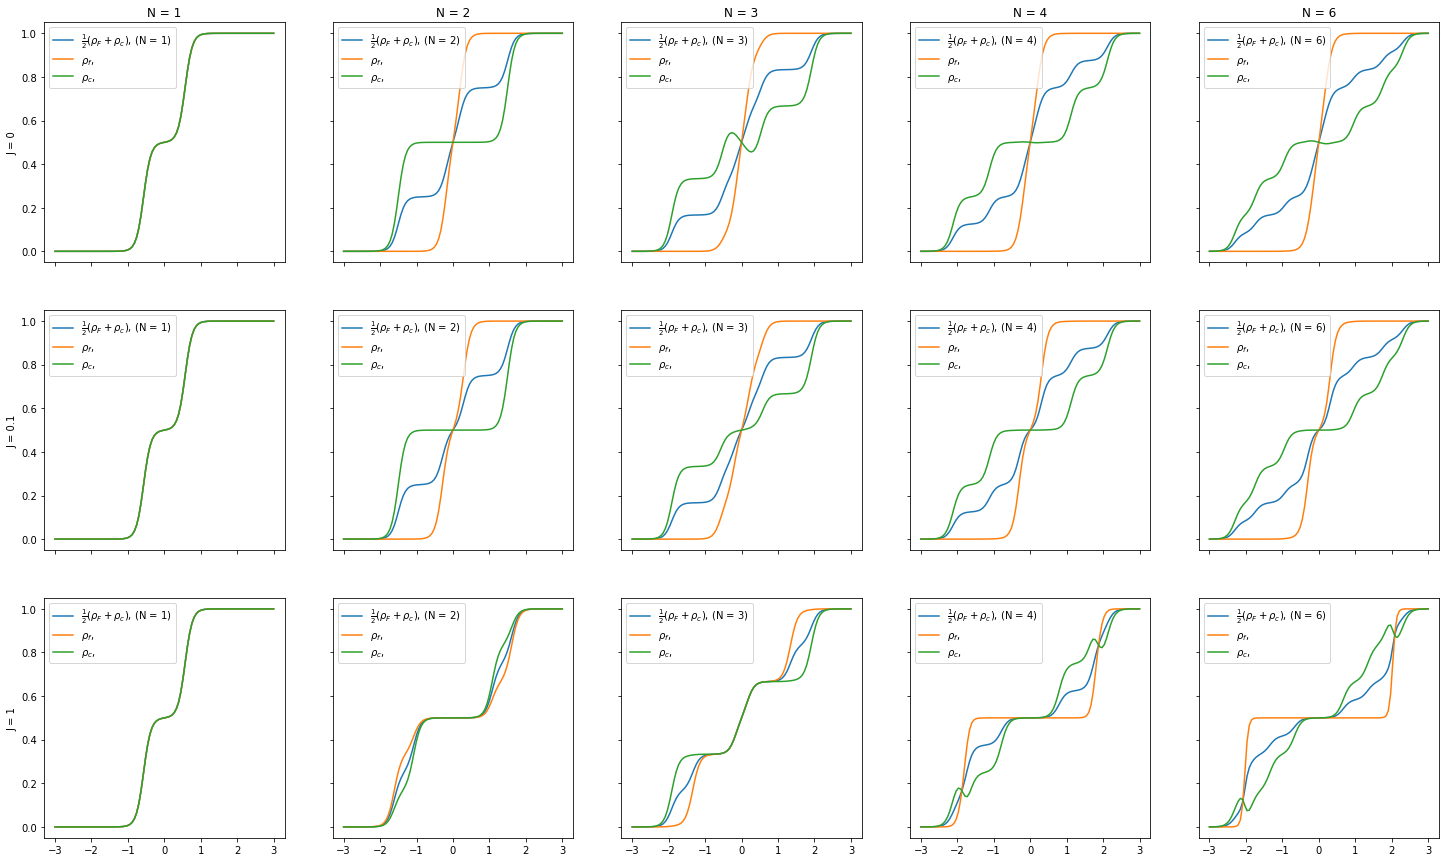

In [4]:
beta = 10
U = 1
Js = [0, 0.1, 1]
mu = np.linspace(-3,3,100)
Ns = [1,2,3,4,6]
ts = 1

f, axes = plt.subplots(len(Js),len(Ns),figsize = (len(Ns)*5,len(Js)*5), sharex = 'col', sharey = 'row')

for row, J in zip(axes, Js):
    for ax, N in zip(row, Ns):
        J_matrix = interaction_matrix(N, 1.5, J, normalise = True, dtype = np.float64)
        Nf, Nc = np.array([direct_N(N, m, beta, U, J=J_matrix, t=t) for m in mu]).T
        Nt = (Nf + Nc)
        ax.plot(mu, Nt/(2*N), label = r'$\frac{1}{2}(\rho_F + \rho_c)$,' +f' (N = {N})')
        ax.plot(mu, Nf/N, label = r'$\rho_f$,')
        ax.plot(mu, Nc/N, label = r'$\rho_c$,')
        ax.legend()
        
for ax,N in zip(axes[0],Ns): ax.set(title = f'N = {N}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 

CPU times: user 20.9 s, sys: 4 ms, total: 21 s
Wall time: 20.9 s


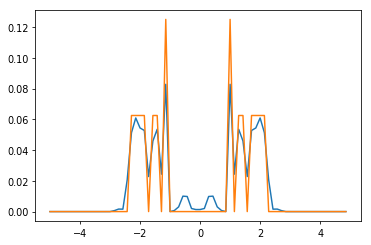

In [199]:
%%time
def direct_spectrum(system_size, mu, beta, U, J, t = 1):
    Z = 0
    Nf = 0
    Nc = 0
    eigenval_bins = np.linspace(-5, 5, 70 + 1)
    eigenval_hist = np.zeros(eigenval_bins.shape[0]-1, dtype = np.float64)
    IPR_hist = np.zeros(eigenval_bins.shape[0]-1, dtype = np.float64)
    
    muf = muc = mu
    for state in product((0,1), repeat = system_size):
        state = np.array(state)
        if system_size > 1:
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J, t)
        elif system_size == 1:
            evals = np.array([U*(state - 1/2)]) - muc
            Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
            Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))    

        Boltz_factor = np.exp(- beta * (Ff + Fc))
        Z += Boltz_factor
        Nf += np.sum(state) * Boltz_factor
        Nc += np.sum(1 / (1 + np.exp(beta * evals))) * Boltz_factor
        
        eigenval_hist += np.histogram(evals, eigenval_bins)[0] * Boltz_factor
    
    eigenval_hist = eigenval_hist / np.sum(eigenval_hist)
    return Nf / Z, Nc / Z, eigenval_hist, eigenval_bins

eigens = np.zeros((2,70), dtype = np.float64)
system_size = 16
for J in [0,1]:
    J_matrix = interaction_matrix(system_size, alpha = 1.5, J = J, normalise = True, dtype = np.float64)
    Nf, Nc, eigenval_hist, eigenval_bins = direct_spectrum(system_size, mu = 0, beta = 1/0.07, U = 2, J = J_matrix, t = 1)
    eigens[J] = eigenval_hist
    plt.plot(eigenval_bins[:-1], eigenval_hist)

/workspace/tch14/conda-envs/cmth_intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/workspace/tch14/conda-envs/cmth_intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


CPU times: user 21.6 s, sys: 20 ms, total: 21.7 s
Wall time: 21.7 s


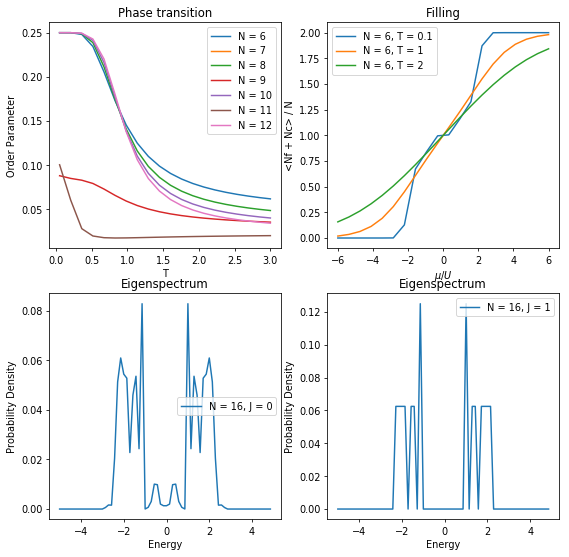

In [210]:
%%time
def direct(system_size, mu, beta, U, J, t = 1, alpha = 1.5):
    Z = 0
    Nf = Nc = Mf = M2f = 0
    muf = muc = mu
    A = 2*(np.arange(system_size) % 2) - 1
    J_matrix = interaction_matrix(system_size, alpha, J, normalise = True, dtype = np.float64)
    
    for state in product((0,1), repeat = system_size):
        state = np.array(state)
        if system_size > 1:
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
        elif system_size == 1:
            evals = np.array([U*(state - 1/2)]) - muc
            Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
            Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))    

        Boltz_factor = np.exp(- beta * (Ff + Fc))
        Z += Boltz_factor
        Nf += np.sum(state) * Boltz_factor
        Nc += np.sum(1 / (1 + np.exp(beta * evals))) * Boltz_factor
        Mf += np.sum((state - 1/2) * A) * Boltz_factor
        M2f += np.sum((state - 1/2) * A)**2 * Boltz_factor
    
    return Nf / Z, Nc / Z, Mf / Z, M2f / Z

f,axs = plt.subplots(2,2,figsize = (textwidth*1.5,textwidth*1.5))
axs = axs.flatten()
T = np.linspace(0.05, 3, 20)
beta = 1/T

#for system_size in [6]:
for system_size in [6,7,8,9,10,11,12]:
    Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = 1, J = 1, t = 1) for b in beta]).T
    axs[0].plot(T, M2f / system_size**2, label = f'N = {system_size}')
    
mu = np.linspace(-6, 6, 20)
system_size = 6
for T in [0.1,1,2]:
    Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = m, beta = 1/T, U = 1, J = 1, t = 1) for m in mu]).T
    axs[1].plot(mu, (Nf+Nc)/system_size, label = f'N = {system_size}, T = {T}')
    
    
for J in [0,1]:
    axs[2+J].plot(eigenval_bins[:-1], eigens[J], label = f'N = 16, J = {J}')
    
axs[0].set(title = 'Phase transition', ylabel = 'Order Parameter', xlabel = 'T')
axs[1].set(title = 'Filling', ylabel = '<Nf + Nc> / N', xlabel = '$\mu / U$')
axs[2].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy')
axs[3].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy')

for ax in axs: ax.legend()
f.savefig("/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Notes for Jo May '19/direct_partition_function.eps")

In [177]:
from scipy.linalg import eigh_tridiagonal, LinAlgError, circulant
from math import exp

#a catch all datalogger
class DataLogger(object):
    def __init__(self):
        pass
        
    def start(self, N_steps, N_sites):
        self.A = 2*(np.arange(N_sites) % 2) - 1
        self.Fc, self.Ff, self.Nf, self.Nc, self.M2f = np.zeros((N_steps,5), dtype = np.float64).T ##The way this is laid out in memory may affect the speed
        self.state, self.eigenvals = np.zeros((2,N_steps,N_sites), dtype = np.float64)
        self.eigenvecs = np.zeros((N_steps,N_sites,N_sites), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.Ff[j] = Ff
        self.Fc[j] = Fc
        self.Nf[j] = np.sum(state)
        self.Nc[j] = np.sum(1/(1 + np.exp(beta * evals)))
        self.M2f[j] = np.sum((state - 1/2) * self.A)**2
        self.state[j] = state
        self.eigenvals[j] = evals

    
    def return_vals(self):
        return self

        

def FK_mcmc(
    state,            
    N_steps = 100, N_burn_in = 10,
    mu = 0, beta = 0.1, J=1, alpha=1.5, U = 1, t=1,
    logger = None,
    ):
    
    N_sites = state.shape[0]
    random_numbers = np.random.rand(N_steps + N_burn_in, N_sites)
    J_matrix = interaction_matrix(N_sites, 1.5, J, normalise = True, dtype = np.float64)
    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    old_F = Ff + Fc
    if logger == None: logger = DataLogger()
    logger.start(N_steps, N_sites)
    
    for i in range(N_steps + N_burn_in):
        for site in range(N_sites):
            state[site] = 1 if state[site] == 0 else 0
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
            dF = (Ff+Fc) - old_F
            
            #if the move is rejected flip the site back and pretend nothing happened
            if dF > 0 and exp(- beta * dF) < random_numbers[i, site]:
                state[site] = 1 if state[site] == 0 else 0
            else:
                old_F = Ff+Fc
    
        if i >= N_burn_in:
                j = i - N_burn_in
                logger.update(j, Ff, Fc, state, evals, evecs,  mu, beta, J_matrix)

    return logger.return_vals()

In [225]:
class Eigenspectrum(object):
    def __init__(self, bins = 70, limit = 5):
        self.eigenval_bins = np.linspace(-limit, limit, bins + 1)
    
    def start(self, N_steps, N_sites):
        self.N_steps = N_steps
        self.eigenvals = np.zeros((N_steps,N_sites), dtype = np.float64)
        self.eigenval_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)
        self.IPR_histogram = np.zeros(eigenval_bins.shape[0]-1, dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.eigenval_histogram[j] = np.histogram(evals, self.eigenval_bins)[0]
    
    def return_vals(self):
        bins = self.eigenval_bins
        histogram = np.mean(self.eigenval_histogram, axis = 0)
        normalisation_factor = np.sum(histogram)
        histogram = histogram / normalisation_factor 
        dhistogram = np.std(self.eigenval_histogram, axis = 0) / normalisation_factor / np.sqrt(self.N_steps)
        return bins, histogram, dhistogram

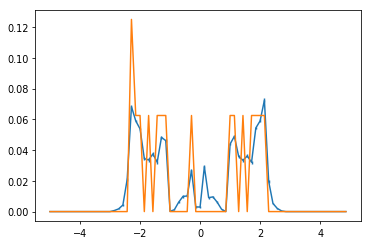

In [206]:
eigens_mcmc = np.zeros((2,70), dtype = np.float64)
deigens_mcmc = np.zeros((2,70), dtype = np.float64)
system_size = 16
for J in [0,1]:
    eigenval_bins, eigenval_hist, deigenval_hist = FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = 1000, N_burn_in = 200, mu = 0, beta = 1/0.07, U = 2, J=J, alpha=1.5, t = 1,
                                  logger=Eigenspectrum()) 
        
    eigens_mcmc[J] = eigenval_hist
    deigens_mcmc[J] = deigenval_hist
    plt.errorbar(eigenval_bins[:-1], eigenval_hist, yerr = deigenval_hist)

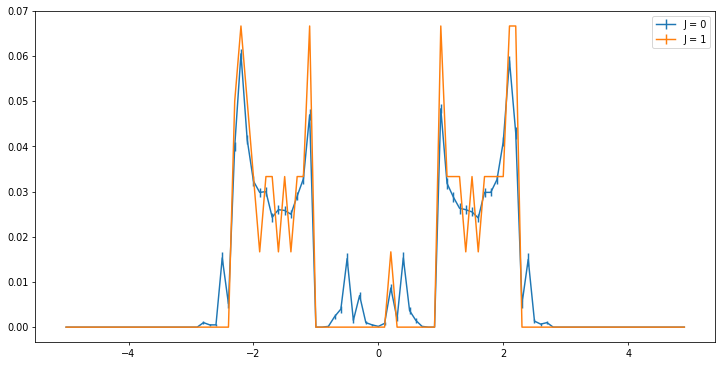

In [226]:
class Eigenspectrum_IPR(object):
    def __init__(self, bins = 70, limit = 5):
        self.eigenval_bins = np.linspace(-limit, limit, bins + 1)
    
    def start(self, N_steps, N_sites):
        self.N_steps = N_steps
        self.eigenvals = np.zeros((N_steps,N_sites), dtype = np.float64)
        self.eigenval_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)
        self.IPR_histogram = np.zeros(eigenval_bins.shape[0]-1, dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        IPRs = some_function(eigenvecs)
        
        #these are the indices corresponding to the energy bin that each energy and IPR should go into
        indices = np.searchsorted(self.eigenval_bins, evals)
        
        #
        self.eigenval_histogram[j] = np.bincount(indices)
        
        #need to group the IPRs by the bin they should go into 
    
    def return_vals(self):
        bins = self.eigenval_bins
        histogram = np.mean(self.eigenval_histogram, axis = 0)
        normalisation_factor = np.sum(histogram)
        histogram = histogram / normalisation_factor 
        dhistogram = np.std(self.eigenval_histogram, axis = 0) / normalisation_factor / np.sqrt(self.N_steps)
        return bins, histogram, dhistogram

f,ax = plt.subplots(figsize = (2*textwidth, textwidth))

system_size = 60
for J in [0,1]:
    eigenval_bins, eigenval_hist, deigenval_hist = FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = 100, N_burn_in = 10, mu = 0, beta = 1/0.07, U = 2, J=J, alpha=1.5, t = 1,
                                  logger=Eigenspectrum_IPR(bins = 100)) 

    ax.errorbar(eigenval_bins[:-1], eigenval_hist, yerr = deigenval_hist, label = f'J = {J}')
ax.legend()

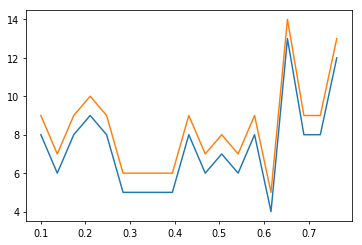

In [243]:
data = np.random.rand(200)
bins = np.linspace(0.1,0.8,20)

hist, _ = np.histogram(data, bins)
indices = np.searchsorted(bins, data)
hist2 = np.bincount(indices)

plt.plot(bins[:-1], hist)
plt.plot(bins[:-1], hist2[1:-1] + 1)

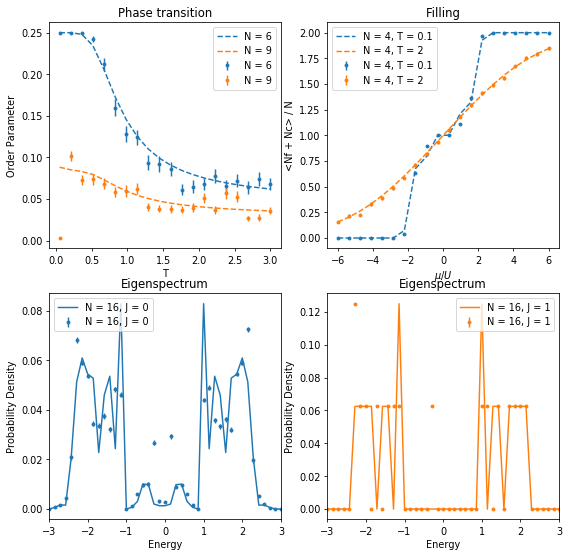

In [209]:
f,axs = plt.subplots(2,2,figsize = (textwidth*1.5,textwidth*1.5))
axs = axs.flatten()

#plot magnetisation as a function of T
class Magnetisation_squared(object):
    def start(self, N_steps, N_sites):
        self.A = 2*(np.arange(system_size) % 2) - 1
        self.M2f = np.zeros((N_steps), dtype = np.float64).T
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.M2f[j] = np.sum((state - 1/2) * self.A)**2
    
    def return_vals(self):
        return np.mean(self.M2f), np.std(self.M2f) / np.sqrt(self.M2f.shape[0])
    
class Density(object):
    def start(self, N_steps, N_sites):
        self.N = np.zeros((N_steps), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.N[j] = np.sum(state) + np.sum(1/(1 + np.exp(beta * evals)))
    
    def return_vals(self):
        return np.mean(self.N), np.std(self.N) / np.sqrt(self.N.shape[0])

N_burn_in = 50
N_steps = 100
    
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
T = np.linspace(0.05, 3, 20)
beta = 1/T
system_sizes = [6,9]


for system_size,color in zip(system_sizes, colors):
#for system_size in [6,7,8,9,10,11,12]:
    _, _, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = 1, J = 1, t = 1) for b in beta]).T
    axs[0].plot(T, M2f / system_size**2, label = f'N = {system_size}', color = color, linestyle = '--')
    
    M2f, dM2f = np.array([FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = N_steps, N_burn_in = N_burn_in, mu = 0, beta = b, J=1, alpha=1.5, U = 1,
                                  logger=Magnetisation_squared()) for b in beta]).T
    axs[0].errorbar(T, M2f / system_size**2, yerr= dM2f / system_size**2, label = f'N = {system_size}', color = color, linestyle = '', marker = '.')

    
mu = np.linspace(-6, 6, 20)
system_size = 4
Ts = [0.1,2]

for T,color in zip(Ts, colors):
    Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = m, beta = 1/T, U = 1, J = 1, t = 1) for m in mu]).T
    axs[1].plot(mu, (Nf+Nc)/system_size, label = f'N = {system_size}, T = {T}', color = color, linestyle = '--')
    
    N, dN = np.array([FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = N_steps, N_burn_in = N_burn_in, mu = m, beta = 1/T, J=1, alpha=1.5, U = 1,
                                  logger=Density()) for m in mu]).T
    axs[1].errorbar(mu, N / system_size, yerr = dN / system_size, label = f'N = {system_size}, T = {T}', color = color, linestyle = '', marker = '.')
    

for J,color in zip([0,1],colors):
    axs[2+J].plot(eigenval_bins[:-1], eigens[J], label = f'N = 16, J = {J}', color = color)
    axs[2+J].errorbar(eigenval_bins[:-1], eigens_mcmc[J], yerr = deigens_mcmc[J], label = f'N = 16, J = {J}', marker = '.', linestyle = '', color = color)

axs[0].set(title = 'Phase transition', ylabel = 'Order Parameter', xlabel = 'T')
axs[1].set(title = 'Filling', ylabel = '<Nf + Nc> / N', xlabel = '$\mu / U$')
axs[2].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy', xlim = (-3,3))
axs[3].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy', xlim = (-3,3))

for ax in axs: ax.legend()
f.savefig("/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Notes for Jo May '19/mcmc_partition_function.eps")

(50,) (50,) (50,)
(50,) (50,) (50,)
(50,) (50,) (50,)
(50,) (50,) (50,)
(50,) (50,) (50,)
(50,) (50,) (50,)
(50,) (50,) (50,)
(50,) (50,) (50,)
(50,) (50,) (50,)
(50,) (50,) (50,)


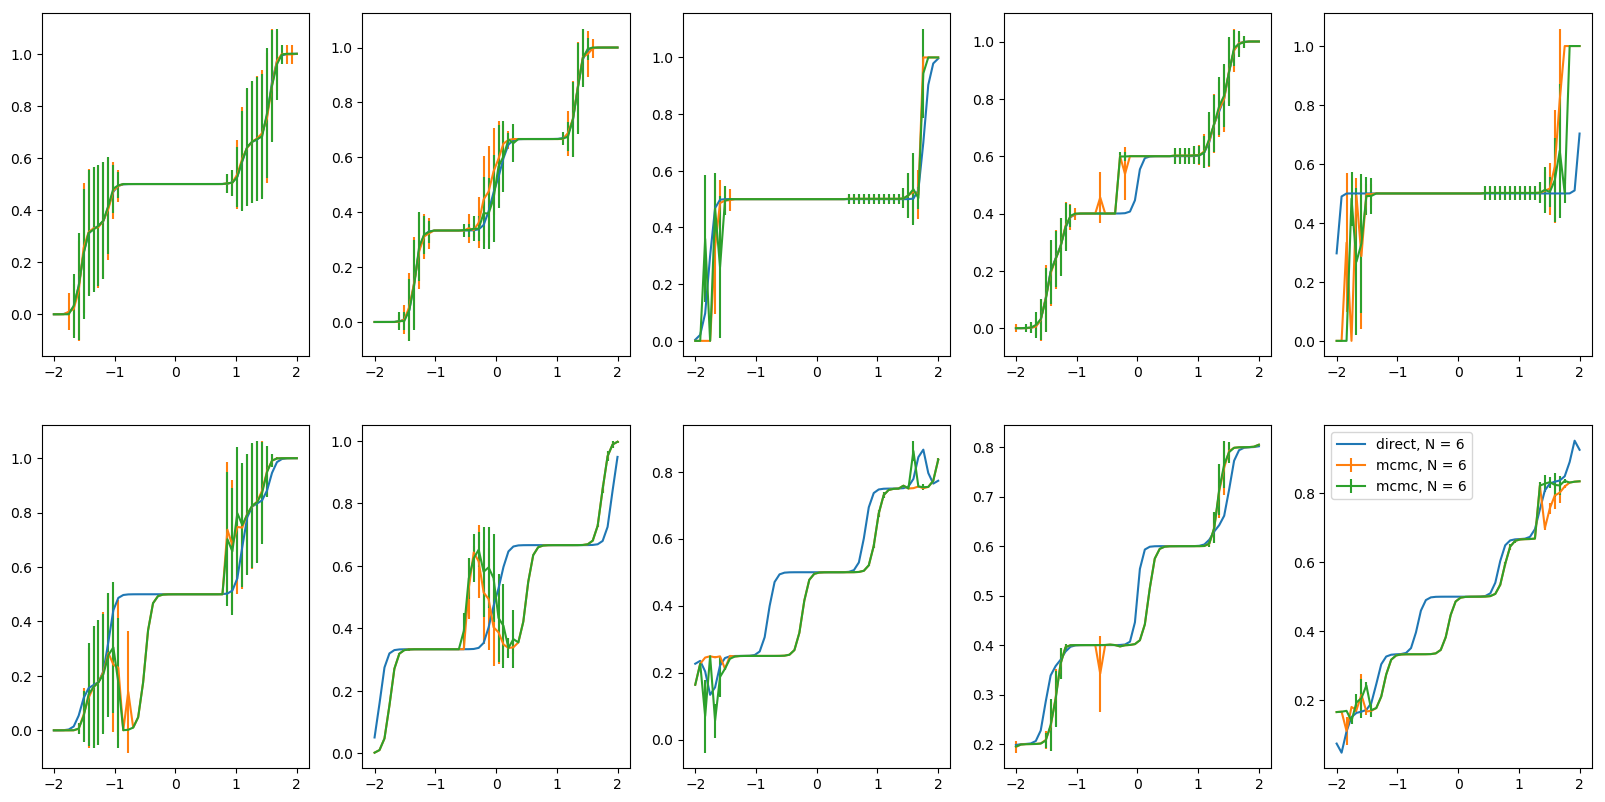

In [125]:
#%%time
from scipy.linalg import eigh_tridiagonal, LinAlgError, circulant
from math import exp

def FK_mcmc(
    state,            
    N_steps = 100, N_burn_in = 10,
    mu = 0, beta = 0.1, J=1, alpha=1.5, U = 1
    ):
    
    random_numbers = np.random.rand(N_steps + N_burn_in, state.shape[0])
    J_matrix = interaction_matrix(state.shape[0], 1.5, J, normalise = True, dtype = np.float64)
    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix)
    old_F = Ff + Fc
    
    Fcs,Ffs = np.zeros((2,N_steps), dtype = np.float64)
    Classical_Fs = np.zeros(N_steps, dtype = np.float64)
    states = np.zeros((N_steps,state.shape[0]), dtype = np.float64)
    eigen_val_list = np.zeros((N_steps,state.shape[0]), dtype = np.float64)
    Nf, dNf, Nc, dNc = np.zeros((4,N_steps), dtype = np.float64)
    
    for i in range(N_steps + N_burn_in):
        for site in range(state.shape[0]):
            state[site] = 1 if state[site] == 0 else 0
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix)
            dF = (Ff+Fc) - old_F
            
            #if the move is rejected flip the site back and pretend nothing happened
            if dF > 0 and exp(- beta * dF) < random_numbers[i, site]:
                state[site] = 1 if state[site] == 0 else 0
            else:
                old_F = Ff+Fc
    
        if i >= N_burn_in:
                j = i - N_burn_in
                Ffs[j] = Ff
                Fcs[j] = Fc
                states[j] = state
                eigen_val_list[j] = evals 
                Nf[j] = np.sum(state)
                Nc[j] = np.sum(1/(1 + np.exp(beta * evals)))
    
    return Fcs, Ffs, states, eigen_val_list, Nf, Nc


beta = 20
U = 1
mu = np.linspace(-2,2,50)
N_steps = 200
alpha = 1.5
J = 1

Ns = np.arange(2,7)
f, axes = plt.subplots(2, len(Ns), figsize = (20,10))

for (axf,axc),N in zip(axes.T,Ns):
    J_matrix = interaction_matrix(N, alpha, J=J, normalise = True, dtype = np.float64)
    Nf, Nc = np.array([direct_N(N, m, beta, U, J=J_matrix) for m in mu]).T
    Nt = (Nf + Nc) / N
    axf.plot(mu, Nf / N, label = f'direct, N = {N}')
    axc.plot(mu, Nc / N, label = f'direct, N = {N}')
    
    for i in range(2):
        Nf, dNf, Nc, dNc  = np.zeros((4,mu.shape[0]), dtype = np.float64)
        for i,m in enumerate(mu):
            state = np.zeros(N, dtype = np.float64)
            Fs, Classical_Fs, states, eigen_val_list, mNf, mNc = FK_mcmc(
            state,            
            N_steps = N_steps, N_burn_in = 0,
            mu = m, beta = beta, J=J, alpha=alpha, U = U
            )  

            Nf[i] = np.mean(mNf) / (N)
            dNf[i] = np.std(mNf) / (N)
            Nc[i] = np.mean(mNc) / (N)
            dNc[i] = np.std(mNc) / (N)

        print(mu.shape, Nf.shape, dNf.shape)
        axf.errorbar(mu, Nf, yerr = dNf, label = f'mcmc, N = {N}')
        axc.errorbar(mu, Nc, yerr = dNc, label = f'mcmc, N = {N}')
    
plt.legend()
#plt.savefig()

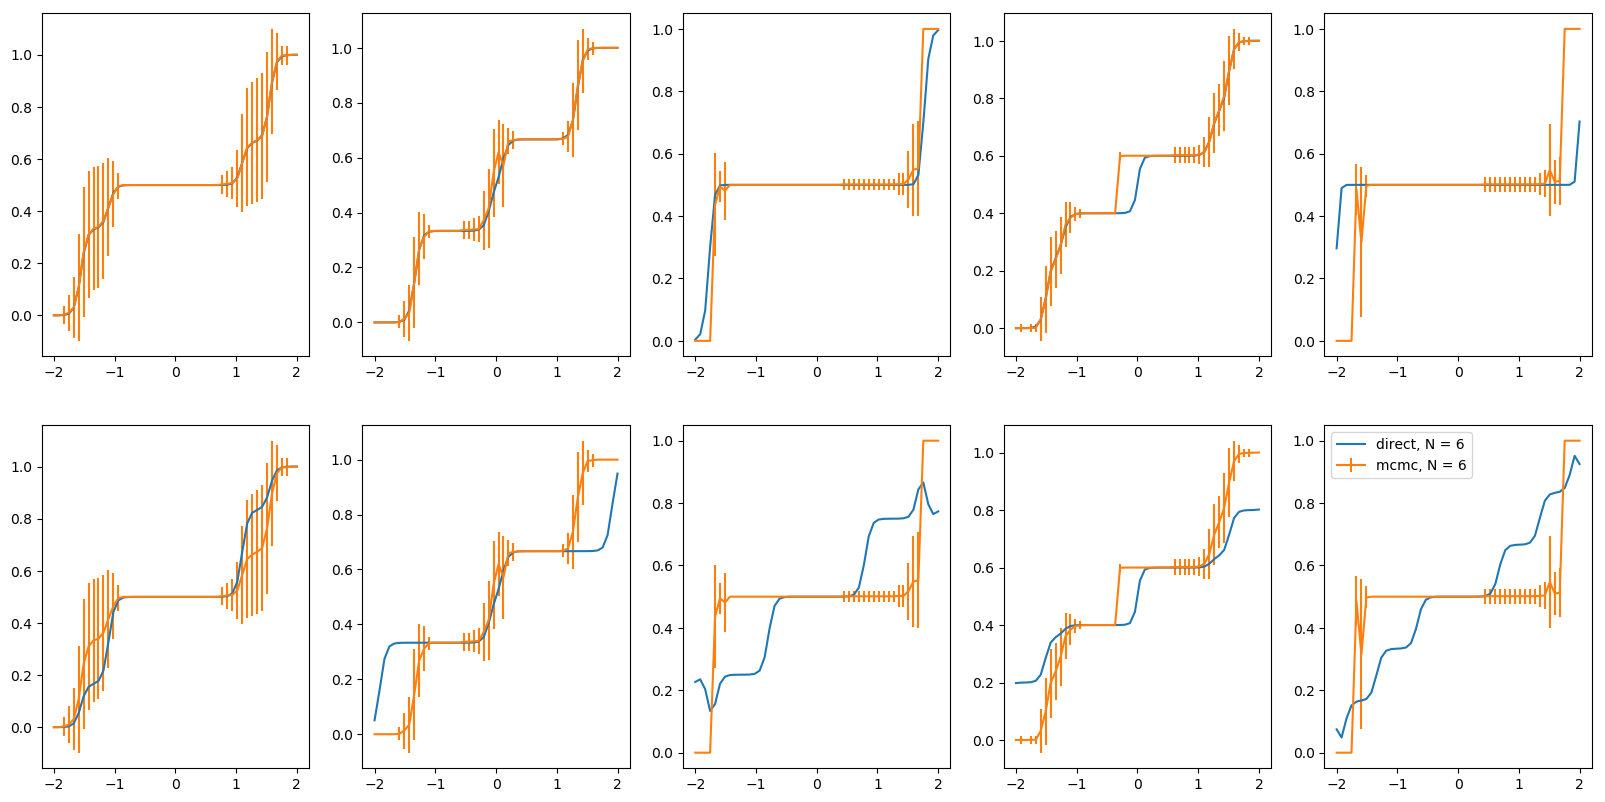

In [123]:



beta = 20
U = 1
mu = np.linspace(-2,2,50)
N_steps = 200
alpha = 1.5
J = 1

Ns = np.arange(2,7)
f, axes = plt.subplots(2, len(Ns), figsize = (20,10))

for (axf,axc),N in zip(axes.T,Ns):
    J_matrix = interaction_matrix(N, alpha, J=J, normalise = True, dtype = np.float64)
    Nf, Nc = np.array([direct_N(N, m, beta, U, J=J_matrix) for m in mu]).T
    Nt = (Nf + Nc) / N
    axf.plot(mu, Nf / N, label = f'direct, N = {N}')
    axc.plot(mu, Nc / N, label = f'direct, N = {N}')
    

    Nf, dNf, Nc, dNc = np.zeros((4,mu.shape[0]), dtype = np.float64)
    for i,m in enumerate(mu):
        state = np.zeros(N, dtype = np.float64)
        log = FK_mcmc(
        state,            
        N_steps = N_steps, N_burn_in = 0,
        mu = m, beta = beta, J=J, alpha=alpha, U = U
        )  
        
        Nf[i] = np.mean(log.Nf) / (N)
        dNf[i] = np.std(log.Nf) / (N)
        Nc[i] = np.mean(log.Nf) / (N)
        dNc[i] = np.std(log.Nf) / (N)
    
    axf.errorbar(mu, Nf, yerr = dNf, label = f'mcmc, N = {N}')
    axc.errorbar(mu, Nc, yerr = dNc, label = f'mcmc, N = {N}')
    
plt.legend()
#plt.savefig()